# Fleet Utilization Rate Analysis by Location

## 1. Library Imports

In [2]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 2. Data Loading

Connecting to the database and retrieving records from the ft_vehicle_Rentals table.

In [3]:
conn = sqlite3.connect('../data/fast_rent_a_car.db')

In [5]:
query = "SELECT * FROM ft_vehicle_Rentals"
df = pd.read_sql(query, conn, parse_dates=['Start_Date', 'End_Date'])

df.head(), df.dtypes

(   Rental_ID  Vehicle_ID  Location_ID Start_Date   End_Date
 0          1           1            1 2023-05-02 2023-05-04
 1          2           1            1 2023-05-05 2023-05-07
 2          3           1            1 2023-05-08 2023-05-09
 3          4           1            1 2023-05-10 2023-05-13
 4          5           1            1 2023-05-14 2023-05-15,
 Rental_ID               int64
 Vehicle_ID              int64
 Location_ID             int64
 Start_Date     datetime64[ns]
 End_Date       datetime64[ns]
 dtype: object)

## 3. Preliminary Analysis

**Fleet Variation Over Time**

First, we will visualize the fleet size variation by location over time.

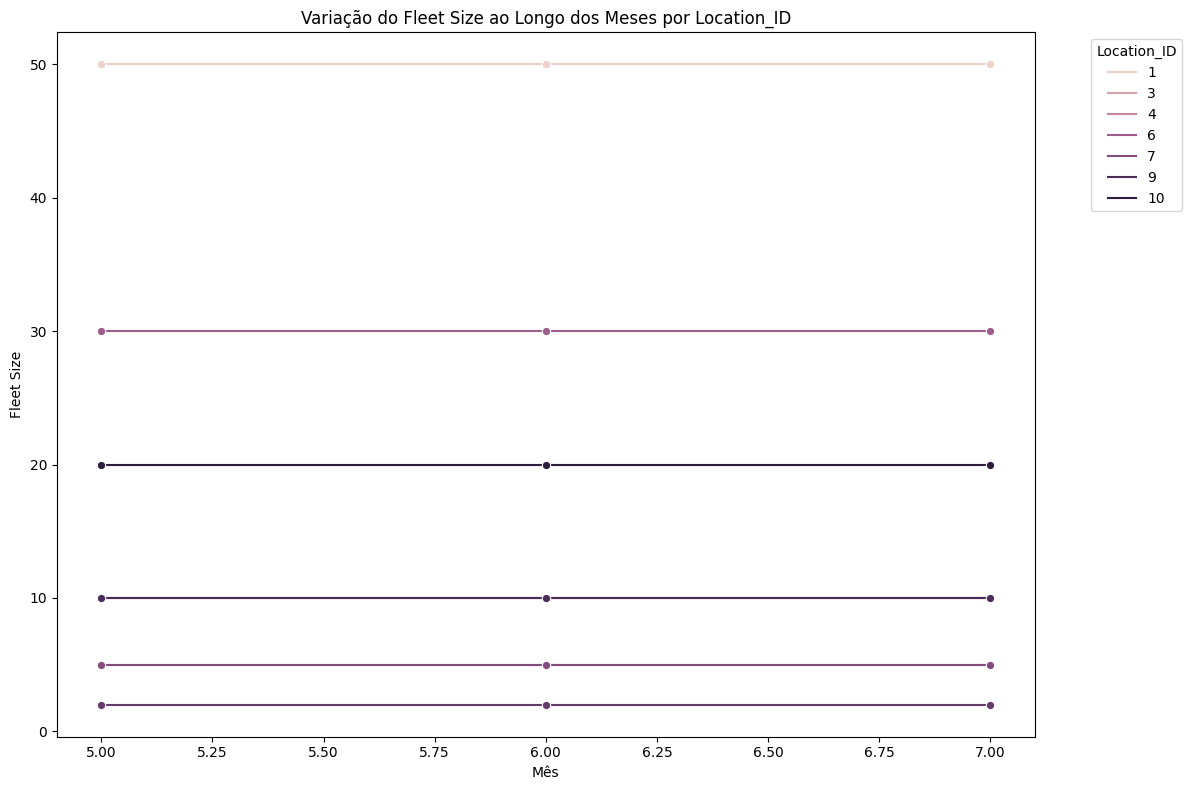

,Location_ID,month,fleet_size
0,1,5,50
1,1,6,50
2,1,7,50
3,2,5,20
4,2,6,20
5,2,7,20
6,3,5,10
7,3,6,10
8,3,7,10
9,4,5,5


In [6]:
df['month'] = df['Start_Date'].dt.month
fleet_size_over_time = df.groupby(['Location_ID', 'month']).agg(
    fleet_size=('Vehicle_ID', 'nunique')).reset_index()
location_ids = fleet_size_over_time['Location_ID'].unique()

plt.figure(figsize=(12, 8))
sns.lineplot(data=fleet_size_over_time, x='month', y='fleet_size',
             hue='Location_ID', hue_order=location_ids, marker='o')
plt.title('Variação do Fleet Size ao Longo dos Meses por Location_ID')
plt.ylabel('Fleet Size')
plt.xlabel('Mês')
plt.legend(title='Location_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

fleet_size_over_time

Ok, it didn't change in any store.

#### Rental Period

We establish the total duration over which the rentals have been recorded.


In [7]:
first_date = df['Start_Date'].min()
last_date = df['End_Date'].max()
total_days = (last_date - first_date).days + 1

print(f"The fleet was available for {total_days} days")

The fleet was available for 93 days


## 4. Utilization Rate

Calculating Rental Days


In [17]:
df['Rental_Days'] = (df['End_Date'] - df['Start_Date']).dt.days + 1
total_rental_days = df.groupby(['Location_ID', 'Vehicle_ID'])[
    'Rental_Days'].sum()

total_rental_days.loc[3]

Location_ID  Vehicle_ID
1            1              81
             2              83
             3              89
             4              82
             5              82
                          ... 
10           158            97
             159           106
             160            96
             161            99
             162            99
Name: Rental_Days, Length: 162, dtype: int64

To better understand the number above 93 days, let's check the records where the same vehicle was rented out and returned on the same day.

In [21]:
# Get vehicles with more than 93 rental days
vehicles_over_93_days = total_rental_days[total_rental_days > 93].index.tolist(
)

# Initialize an empty list to store vehicles with overlapping rentals
vehicles_with_overlaps = []

# For each vehicle, check for overlaps
for location_id, vehicle_id in vehicles_over_93_days:
    vehicle_rentals = df[(df['Location_ID'] == location_id) & (
        df['Vehicle_ID'] == vehicle_id)].sort_values('Start_Date')

    overlap_found = False
    for index, (i, row) in enumerate(vehicle_rentals.iterrows()):
        if index == 0:  # skip the first row
            continue
        # Check if start date of current rental is the same as end date of previous rental
        prev_row = vehicle_rentals.iloc[index-1]
        if row['Start_Date'] == prev_row['End_Date']:
            overlap_found = True
            break

    if overlap_found:
        vehicles_with_overlaps.append((location_id, vehicle_id))

print(f"Out of {len(vehicles_over_93_days)} vehicles with more than 93 rental days, {len(vehicles_with_overlaps)} vehicles have overlapping rentals.")

Out of 62 vehicles with more than 93 rental days, 62 vehicles have overlapping rentals.


Upon closer examination of the rental data, we have observed that certain vehicles have accumulated rental durations surpassing the 93-day threshold within our analysis window. This discrepancy is rooted in the business practice where vehicles can be returned and rented out again on the same day. Specifically, in instances where a vehicle is returned in the morning and is rented again later in the same day, both the return and the new rental are counted for that day, essentially double-counting it. This situation is not an anomaly, but rather an indication of high fleet utilization.

In total, `62 vehicles` exhibited this behavior, and all of them had overlapping rentals that can account for their extended rental durations. Given this context and adhering to business rules, we will proceed with our analysis by accepting these values as accurate representations of fleet utilization. This practice ensures that we capture the full potential of each vehicle's availability and usage.

In [20]:
fleet_size_by_location = df.groupby('Location_ID')['Vehicle_ID'].nunique()
total_rental_days_by_location = df.groupby('Location_ID')['Rental_Days'].sum()
utilization_rate = total_rental_days_by_location / \
    (fleet_size_by_location * total_days)

utilization_rate

Location_ID
1     0.900000
2     1.004301
3     1.110753
4     1.156989
5     1.021505
6     0.889247
7     1.015054
8     1.145161
9     1.174194
10    1.038172
dtype: float64

In [21]:
def evaluate_utilization(rate):
    if rate < 0.78:
        return "has too many cars"
    elif rate > 0.86:
        return "needs more fleet"
    else:
        return "has an ideal fleet size"


results = utilization_rate.apply(evaluate_utilization)

print(results)

conn.close()

Location_ID
1     needs more fleet
2     needs more fleet
3     needs more fleet
4     needs more fleet
5     needs more fleet
6     needs more fleet
7     needs more fleet
8     needs more fleet
9     needs more fleet
10    needs more fleet
dtype: object


## 5. Conclusions

Upon analyzing the utilization rate of the fleet across various locations, our findings are consistent and remarkably clear:

For every location, from Location_ID 1 to Location_ID 10, our analysis indicates that each of them "needs more fleet".

#### Interpretation:

A high utilization rate, specifically rates that exceed 86%, implies that the vehicles at these locations are almost consistently rented out. This indicates that the demand for rental vehicles at these locations often meets or exceeds the current supply. There could be potential missed opportunities, as customers might not always find vehicles available when they want to rent.

